In [0]:
class Number:
    def __init__(self, x, y, index, val):
        self.x = x
        self.y = y
        self.index = index
        self.val = val

    def get_x(self):
        return self.x

    def get_y(self):
        return self.y

    def get_index(self):
        return self.index

    def get_val(self):
        return self.val

    def distance(self, point):
        # Euclidean distance beetween this point and other
        import math
        return math.sqrt(abs(self.get_x() - point.get_x()) + 
                         abs(self.get_y() - point.get_y()))

    def encapsulate_numbers(legend_array, img_embed):
        numbers = []
        for i in range(len(legend_array)):
            x_coo = img_embed[i,:][0]
            y_coo = img_embed[i,:][1]
            number = Number(x_coo, y_coo, i, legend_array[i])
            numbers.append(number)
        return numbers


    def neighbours(numbers, same_digit, neighbourhood):
        """
        # same_digit: a boolean. If False, it searches for different numbers 
                                who look like similar.
                                If True, it searches for two similar 
                                representations of the same number.
        # neighbourhood: a tuple. (min_distance, max_distance). 
                        min_distance xor max_distance can be None.
        """
        min_distance = neighbourhood[0]
        max_distance = neighbourhood[1]

        if (min_distance == None and max_distance == None):
            raise ValueError("Just one beetween min_distance and max_distance can be None")

        if (min_distance != None):
            min_distance = neighbourhood[0]
        else:
            min_distance = 0

        if (max_distance != None):
            max_distance = neighbourhood[1]
        else:
            max_distance = 5

        nbs = []
        for num1 in numbers:
            if (num1.get_index() % 1000 == 0):
                print(num1.get_index())
            for num2 in numbers:
                same = True
                if (not same_digit):
                    same = num1.get_val() != num2.get_val()
                else:
                    same = num1.get_val() == num2.get_val()
                if (num1.get_index() != num2.get_index() and
                        min_distance <= num1.distance(num2) <= max_distance and
                        same):
                    nbs.append((num1, num2))
        return nbs

In [0]:
import math
import os
import sys
import numpy as np
from PIL import Image
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

class AnomalousMovingMNIST:
    '''
    Args:
    anom_frames: list of anomalous frame indexes that must appear in the sequence
    num_anoms_per_frame: how many MNIST numbers have to be anomalous in an anomalous frame
    n_clusters: number of clusters to perform K-Means. 
        More clusters imply smaller cluster size, more similarity between instances but less variety.
        Less clusters imply bigger cluster size, less similarity between instances but more variety.
    dataset = {training, test}: specifies whether the dataset should be created from the MNIST training set or test set
    '''
    def __init__(self, 
                 anom_frames,
                 num_anoms_per_frame,
                 type_of_anomaly,
                 num_sequences=20000,
                 shape=(64, 64),
                 num_frames=30,
                 original_size=28,
                 nums_per_image=2,
                 path_data = '',
                 path_labels = '',
                 path_tSNE = '',
                 n_clusters = 30,
                 dest='anomovingmnistdata',
                 filetype='npz',
                 dataset='test',):
        if(not num_anoms_per_frame in [1,2]):
            raise ValueError("num_anoms_per_frame must be 1 or 2")
        
        if(not dataset in ['training', 'test']):
            raise ValueError("possible values: {training, test}")
        
        self.shape = shape
        self.num_frames = num_frames
        self.num_sequences = num_sequences
        self.original_size = original_size
        self.nums_per_image = nums_per_image
        self.dest = dest
        self.filetype = filetype
        self.dataset = dataset
        self.path_data = path_data
        self.path_labels = path_labels
        self.path_tSNE = path_tSNE
        self.n_clusters = n_clusters
        self.anom_frames = anom_frames
        self.num_anoms_per_frame = num_anoms_per_frame
        self.type_of_anomaly = type_of_anomaly

    def get_mnist_path(self):
        return self.mnist_path
    
    def arr_from_img(self, im, mean=0, std=1):
        '''

        Args:
            im: Image
            shift: Mean to subtract
            std: Standard Deviation to subtract

        Returns:
            Image in np.float32 format, in width height channel format. With values in range 0,1
            Shift means subtract by certain value. Could be used for mean subtraction.
        '''
        width, height = im.size
        arr = im.getdata()
        c = int(np.product(arr.size) / (width * height))

        return (np.asarray(arr, dtype=np.float32).reshape((height, width, c)).transpose(2, 1, 0)) / std

    def get_image_from_array(self, X, index, mean=0, std=1):
        '''

        Args:
            X: Dataset of shape N x C x W x H
            index: Index of image we want to fetch
            mean: Mean to add
            std: Standard Deviation to add
        Returns:
            Image with dimensions H x W x C or H x W if it's a single channel image
        '''
        ch, w, h = X.shape[1], X.shape[2], X.shape[3]
        ret = (((X[index] + mean)) * std).reshape(ch, w, h).transpose(2, 1, 0)#.clip(0, 255).astype(np.uint8)
        if ch == 1:
            ret = ret.reshape(h, w)
        return ret
    

    def get_image_from_array_blank(self, X, index, mean=0, std=1):
        '''

        Args:
            X: Dataset of shape N x C x W x H
            index: Index of image we want to fetch
            mean: Mean to add
            std: Standard Deviation to add
        Returns:
            Image with dimensions H x W x C or H x W if it's a single channel image
        '''
        ch, w, h = X.shape[1], X.shape[2], X.shape[3]
        ret = (((X[index] + mean)) * std).reshape(ch, w, h).transpose(2, 1, 0)#.clip(0, 255).astype(np.uint8)
        ret = np.zeros([1,28,28])
        if ch == 1:
            ret = ret.reshape(h, w)
        return ret

    #Load dataset from sklearn
    def load_dataset_from_sklearn(self, dataset='test', path_data='', path_labels=''):
        data = []
        labels = []
        data_reshaped = []
        if(not(path_data == '' or path_labels == '')):
            data = np.load(path_data, allow_pickle=True)
            labels = np.load(path_labels, allow_pickle=True)
            print('Loaded dataset from file system')
        else:
            from sklearn.datasets import fetch_openml
            print("Downloading MNIST "+dataset+" set from sklearn")
            data, labels = fetch_openml('mnist_784', version=1, return_X_y=True)
            data_reshaped = data.reshape(-1, 1, 28, 28).transpose(0, 1, 3, 2)
            np.save('data', data)
            np.save('labels', labels)
            print(("done"))
        if (dataset == 'training'):
            return data[:60000], data_reshaped[:60000] / np.float32(255), labels[:60000]
        return data[-10000:], data_reshaped[-10000:] / np.float32(255), labels[-10000:]

    def perform_tSNE(self, data, path_tSNE=''):
        img_embed = None
        if(self.path_tSNE==''):
                print("Performing t-SNE on a dataset of shape "+str(data.shape)+"...")
                tsne = TSNE(n_components=2)
                img_embed = tsne.fit_transform(data)
                np.save(self.path_tSNE, img_embed)
        else:
            print("Loading existing t-SNE embedding from file system")
            img_embed = np.load(self.path_tSNE)
            print("done")
        return img_embed
    
    def perform_KMeans(self, embedding, labels, n_clusters):
        print("Performing KMeans. K =",n_clusters)
        clusters_dimension = [0]*n_clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedding)
        distances = KMeans(n_clusters=n_clusters, random_state=0).fit_transform(embedding)
        for i in kmeans.labels_:
                clusters_dimension[i]+=1
        clusters = [ [] for i in range(n_clusters)]
        pos = 0
        for i in kmeans.labels_:
                clusters[i].append(Number(embedding[pos][0], embedding[pos][1], pos, labels[pos]))
                pos+=1

        med = np.argmin(distances, axis=0)
        clusters_others = {}
        for i in range(len(clusters)):
            cluster = clusters[i]
            medoid = med[i]
            others = [x.get_index() for x in cluster if x.get_val()!=str(labels[medoid])]
            clusters_others[medoid]=others

        return clusters, clusters_others

        

    def generate_moving_mnist(self, 
                              dataset='test', 
                              shape=(64, 64), 
                              num_frames=20, 
                              num_sequences=10000, 
                              original_size=28,
                              nums_per_image=2):
        '''

        Args:
        dataset = {test, training}: used to decide if downloading/generating train set or test set
        shape: Shape we want for our moving images (new_width and new_height)
        num_frames: Number of frames in a particular movement/animation/gif
        num_sequences: Number of movement/animations/gif to generate
        original_size: Real size of the images (eg: MNIST is 28x28)
        nums_per_image: Digits per movement/animation/gif.

        Returns:
        Dataset of np.uint8 type with dimensions num_frames * num_sequences x 1 x new_width x new_height

        '''
        if(self.dataset == 'training'):
            print("Generating training set of shape ("+str(num_sequences)+", "+
                  str(num_frames)+", 1, "+str(shape[0])+", "+str(shape[1])+")")
        else:
            print("Generating test set of shape ("+str(num_sequences)+", "+
                  str(num_frames)+", 1, "+str(shape[0])+", "+str(shape[1])+")")
            
        data, mnist, labels = self.load_dataset_from_sklearn(self.dataset, 
                                                                path_data=self.path_data,
                                                                 path_labels=self.path_labels)
        
        img_embed = self.perform_tSNE(data, self.path_tSNE)
        _, med_other = self.perform_KMeans(img_embed, labels, n_clusters=self.n_clusters)
        '''
        index_list = medoids
        index_list_false = candidates
        mnist_false = data[index_list_false].reshape(-1, 1, 28, 28)#.transpose(0, 1, 3, 2)
        '''
        mnist = data.reshape(-1, 1, 28, 28)#.transpose(0, 1, 3, 2)
        
        print("Building dataset...")
        width, height = shape
        # Get how many pixels can we move around a single image
        lims = (x_lim, y_lim) = width - original_size, height - original_size

        # Create a dataset of shape of num_frames * num_sequences x 1 x new_width x new_height
        # Eg : 3000000 x 1 x 64 x 64
        dataset = np.empty((num_frames * num_sequences, 1, width, height), dtype=np.uint8)

        for img_idx in range(num_sequences):
            direcs = np.pi * (np.random.rand(nums_per_image) * 2 - 1)
            speeds = np.random.randint(5, size=nums_per_image) + 2
            veloc = np.asarray(
                [(speed * math.cos(direc), speed * math.sin(direc)) for direc, speed in zip(direcs, speeds)])
            
            # Get a list containing two PIL images randomly sampled from the database
            #casual_index = np.random.randint(0, mnist.shape[0], nums_per_image)
            casual_index = np.random.randint(0, self.n_clusters, nums_per_image)
            mnist_images = []
            image_false = None
            mnist_images_false = None
            medoids = list(med_other.keys())

            for r in casual_index:
                mnist_images.append(Image.fromarray(self.get_image_from_array(mnist, medoids[r], mean=0)).resize((original_size, original_size), Image.ANTIALIAS))
            
            anom_list_med_1 = med_other[medoids[casual_index[0]]]
            anom_list_med_2 = med_other[medoids[casual_index[1]]]
            np.random.shuffle(anom_list_med_1)
            np.random.shuffle(anom_list_med_2)
            anom_index_1 = anom_list_med_1[0]
            anom_index_2 = anom_list_med_2[0]
            image_false1 = Image.fromarray(self.get_image_from_array(mnist, anom_index_1, mean=0)).resize((original_size, original_size), Image.ANTIALIAS)
            image_false2 = Image.fromarray(self.get_image_from_array(mnist, anom_index_2, mean=0)).resize((original_size, original_size), Image.ANTIALIAS)
            
            if(self.num_anoms_per_frame == 1):
                rand_idx = np.random.randint(2)
                mnist_images_false = [image_false1, image_false2]
                mnist_images_false[rand_idx] = mnist_images[rand_idx]

            if(self.num_anoms_per_frame == 2):
                mnist_images_false = [image_false1, image_false2]

            # Generate tuples of (x,y) i.e initial positions for nums_per_image (default : 2)
            positions = np.asarray(
                [(np.random.rand() * x_lim, np.random.rand() * y_lim) for _ in range(nums_per_image)])
            positions_false = np.asarray(
                [(np.random.rand() * x_lim, np.random.rand() * y_lim) for _ in range(nums_per_image)])

            # Generate new frames for the entire num_framesgth
            for frame_idx in range(num_frames):
                canvases = [Image.new('L', (width, height)) for _ in range(nums_per_image)]
                canvas = np.zeros((1, width, height), dtype=np.float32)

                # In canv (i.e Image object) place the image at the respective positions
                # Super impose both images on the canvas (i.e empty np array)
                for i, canv in enumerate(canvases):
                    im = mnist_images[i]
                    if(frame_idx in self.anom_frames):
                        im = mnist_images_false[i]    
                        #canv.paste(im, tuple(positions_false[i].astype(int)))
                    #else:    
                    canv.paste(im, tuple(positions[i].astype(int)))
                    canvas += self.arr_from_img(canv, mean=0)

                # Get the next position by adding velocity
                next_pos = positions + veloc

                # Iterate over velocity and see if we hit the wall
                # If we do then change the  (change direction)
                for i, pos in enumerate(next_pos):
                    for j, coord in enumerate(pos):
                        if coord < -2 or coord > lims[j] + 2:
                            veloc[i] = list(list(veloc[i][:j]) + [-1 * veloc[i][j]] + list(veloc[i][j + 1:]))

                # Make the permanent change to position by adding updated velocity
                positions = positions + veloc

                # Add the canvas to the dataset array
                dataset[img_idx * num_frames + frame_idx] = ((canvas).clip(0, 255)).astype(np.float32)
        #Reshape dataset to have a shape like (30, 100, 1, 64, 64)
        dataset = dataset.reshape(num_sequences, num_frames, 1, width, height)
        print("done! :)")
        return dataset

    def generate_ano_mnist(self):
        shape = self.shape
        num_frames = self.num_frames
        num_sequences = self.num_sequences
        original_size = self.original_size
        nums_per_image = self.nums_per_image
        dat = self.generate_moving_mnist(dataset='test', shape=shape, num_frames=num_frames, num_sequences=num_sequences,
                                original_size=original_size, nums_per_image=nums_per_image)

        n = num_sequences * num_frames
        if self.filetype == 'npz':
            np.savez(self.dest, anommnist=dat)
        elif filetype == 'jpg':
            for i in range(dat.shape[0]):
                Image.fromarray(self.get_image_from_array(dat, i, mean=0)).save(os.path.join(dest, '{}.jpg'.format(i)))


        

In [123]:
gen = AnomalousMovingMNIST(
    anom_frames=[5],
    num_anoms_per_frame=1,
    type_of_anomaly = None,
    num_frames=20, 
    num_sequences=200, 
    dataset = 'test', 
    path_data='data.npy', 
    path_labels='labels.npy', 
    path_tSNE='tsne.npy', 
    dest='anommnist')

gen.generate_ano_mnist()

Generating test set of shape (200, 20, 1, 64, 64)
Loaded dataset from file system
Loading existing t-SNE embedding from file system
done
Performing KMeans. K = 30
Building dataset...
done! :)


In [0]:
from matplotlib import pyplot as plt

%matplotlib inline

dat = np.load('anommnist.npz')['anommnist']

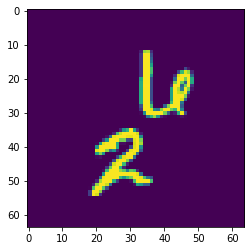

In [129]:
seq = 110
plt.imshow(dat[seq,4,0,])

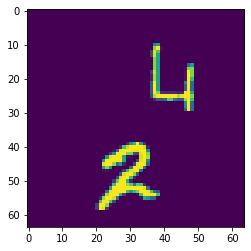

In [130]:
plt.imshow(dat[seq,5,0,])

In [0]:
class SimilarFrame:
    def perform():
        pass

class CasualFrame:
    def perform():
        pass

class BlurredFrame:
    def perform():
        pass